# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import re
import random
from statsmodels.stats.weightstats import ztest

%matplotlib inline

# Import Data

## Import National Map Line Data

In [2]:
road_map = gpd.read_file("data/national-map-line-geojson.geojson")
road_map.head()

,Name,Description,geometry
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"LINESTRING Z (103.85833 1.35595 0.00000, 103.8..."
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"LINESTRING Z (103.85759 1.35611 0.00000, 103.8..."
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"LINESTRING Z (103.86042 1.36817 0.00000, 103.8..."
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"LINESTRING Z (103.85978 1.37228 0.00000, 103.8..."
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"LINESTRING Z (103.85937 1.36913 0.00000, 103.8..."


In [3]:
road_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5135 entries, 0 to 5134
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Name         5135 non-null   object  
 1   Description  5135 non-null   object  
 2   geometry     5135 non-null   geometry
dtypes: geometry(1), object(2)
memory usage: 120.5+ KB


### Extract Expressway Data
The National Line Map data comprises of all the roads in Singapore and we will only extract the expressway data for this project.

In [4]:
# Define a function to extract the road name info
def extract_road_name(x):
    return re.findall(r"td\>(.*?)\<\/td", x)[0]

# Extracting the road name from Description and adding it back into map GeoDataFrame
road_map["road_name"] = road_map["Description"].apply(extract_road_name)
road_map.head()

,Name,Description,geometry,road_name
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"LINESTRING Z (103.85833 1.35595 0.00000, 103.8...",CENTRAL EXPRESSWAY
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"LINESTRING Z (103.85759 1.35611 0.00000, 103.8...",CENTRAL EXPRESSWAY
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"LINESTRING Z (103.86042 1.36817 0.00000, 103.8...",CENTRAL EXPRESSWAY
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"LINESTRING Z (103.85978 1.37228 0.00000, 103.8...",CENTRAL EXPRESSWAY
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"LINESTRING Z (103.85937 1.36913 0.00000, 103.8...",CENTRAL EXPRESSWAY


In [5]:
# Doing a check on the road_names extracted
road_map["road_name"].unique()

array(['CENTRAL EXPRESSWAY', 'CHANGI COAST ROAD', 'CHANGI NORTH CRESCENT',
       'CHANGI SOUTH AVENUE 3', 'CHIN SWEE ROAD', 'CHOA CHU KANG DRIVE',
       'LORNIE HIGHWAY', 'TAMPINES AVENUE 10', 'XILIN AVENUE',
       'CHOA CHU KANG WAY', 'CLEMENTI AVENUE 2', 'CLEMENTI AVENUE 6',
       'CLEMENTI ROAD', 'DAIRY FARM ROAD', 'EAST COAST PARK SERVICE ROAD',
       'AYER RAJAH EXPRESSWAY', 'BUKIT TIMAH EXPRESSWAY',
       'BUKIT TIMAH ROAD', 'CAIRNHILL CIRCLE', 'BALESTIER ROAD',
       'BAYSHORE ROAD', 'BEDOK NORTH AVENUE 3', 'BEDOK NORTH ROAD',
       'BEDOK SOUTH AVENUE 1', 'BENDEMEER ROAD', 'BRADDELL ROAD',
       'BRICKLAND ROAD', 'BUANGKOK EAST DRIVE',
       'BUKIT BATOK EAST AVENUE 3', 'BUKIT BATOK ROAD',
       'BUKIT PANJANG ROAD', 'EAST COAST PARKWAY',
       'KALLANG PAYA LEBAR EXPRESSWAY', 'KRANJI EXPRESSWAY',
       'MARINA COASTAL EXPRESSWAY', 'NICOLL UNDERPASS',
       'PAN ISLAND EXPRESSWAY', 'SELETAR EXPRESSWAY', 'SIME UNDERPASS',
       'TAMPINES EXPRESSWAY', 'ADAM ROAD', 

According to LTA website, there are currently 10 expressways in Singapore. We will take a subset of the road_map dataset comprising of the expressways.
<br>(Ref: https://www.lta.gov.sg/content/ltagov/en/getting_around/driving_in_singapore/expressways.html)
<br>1. Pan Island Expressway (PIE)
<br>2. Ayer Rajah Expressway (AYE)
<br>3. East Coast Parkway (ECP)
<br>4. Central Expressway (CTE)
<br>5. Tampines Expressway (TPE)
<br>6. Kallang-Paya Lebar Expressway (KPE)
<br>7. Seletar Expressway (SLE)
<br>8. Bukit Timah Expressway (BKE)
<br>9. Kranji Expressway (KJE)
<br>10. Marina Coastal Expressway (MCE)

In [6]:
# Subset only the expressways from road_map
expressway_map = road_map[road_map["road_name"].str.lower().str.contains("expressway|parkway")].copy()
expressway_map["road_name"].value_counts()

PAN ISLAND EXPRESSWAY            155
AYER RAJAH EXPRESSWAY             65
CENTRAL EXPRESSWAY                64
TAMPINES EXPRESSWAY               48
SELETAR EXPRESSWAY                38
KALLANG PAYA LEBAR EXPRESSWAY     34
EAST COAST PARKWAY                30
BUKIT TIMAH EXPRESSWAY            24
KRANJI EXPRESSWAY                 21
MARINA COASTAL EXPRESSWAY          8
Name: road_name, dtype: int64

In [7]:
# Combine all geometry data relating to a single road
expressway_map = expressway_map.dissolve(by="road_name", as_index=False)
expressway_map

,road_name,geometry,Name,Description
0,AYER RAJAH EXPRESSWAY,"MULTILINESTRING Z ((103.77133 1.30711 0.00000,...",kml_58,<center><table><tr><th colspan='2' align='cent...
1,BUKIT TIMAH EXPRESSWAY,"MULTILINESTRING Z ((103.77154 1.42324 0.00000,...",kml_88,<center><table><tr><th colspan='2' align='cent...
2,CENTRAL EXPRESSWAY,"MULTILINESTRING Z ((103.85833 1.35595 0.00000,...",kml_1,<center><table><tr><th colspan='2' align='cent...
3,EAST COAST PARKWAY,"MULTILINESTRING Z ((103.98068 1.33908 0.00000,...",kml_204,<center><table><tr><th colspan='2' align='cent...
4,KALLANG PAYA LEBAR EXPRESSWAY,"MULTILINESTRING Z ((103.87639 1.29647 0.00000,...",kml_206,<center><table><tr><th colspan='2' align='cent...
5,KRANJI EXPRESSWAY,"MULTILINESTRING Z ((103.77574 1.39085 0.00000,...",kml_213,<center><table><tr><th colspan='2' align='cent...
6,MARINA COASTAL EXPRESSWAY,"MULTILINESTRING Z ((103.87600 1.29520 0.00000,...",kml_215,<center><table><tr><th colspan='2' align='cent...
7,PAN ISLAND EXPRESSWAY,"MULTILINESTRING Z ((103.66634 1.32705 0.00000,...",kml_218,<center><table><tr><th colspan='2' align='cent...
8,SELETAR EXPRESSWAY,"MULTILINESTRING Z ((103.77023 1.42053 0.00000,...",kml_225,<center><table><tr><th colspan='2' align='cent...
9,TAMPINES EXPRESSWAY,"MULTILINESTRING Z ((103.84840 1.39641 0.00000,...",kml_230,<center><table><tr><th colspan='2' align='cent...


## Import HDB Resale Data

In [8]:
resale = pd.read_csv("data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv", parse_dates=["month"])
resale.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [9]:
resale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140642 entries, 0 to 140641
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   month                140642 non-null  datetime64[ns]
 1   town                 140642 non-null  object        
 2   flat_type            140642 non-null  object        
 3   block                140642 non-null  object        
 4   street_name          140642 non-null  object        
 5   storey_range         140642 non-null  object        
 6   floor_area_sqm       140642 non-null  float64       
 7   flat_model           140642 non-null  object        
 8   lease_commence_date  140642 non-null  int64         
 9   remaining_lease      140642 non-null  object        
 10  resale_price         140642 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 11.8+ MB


In [10]:
resale.describe()

,floor_area_sqm,lease_commence_date,resale_price
count,140642.000000,140642.000000,1.406420e+05
mean,97.717510,1995.433384,4.749322e+05
std,24.092743,13.666275,1.645732e+05
min,31.000000,1966.000000,1.400000e+05
25%,82.000000,1985.000000,3.550000e+05
50%,94.000000,1996.000000,4.450000e+05
75%,113.000000,2006.000000,5.600000e+05
max,249.000000,2019.000000,1.418000e+06


### Enrich HDB Resale Data with Location Coordinates
Using the address of the HDB, we want to obtain their location coordinates from OneMap API

In [11]:
# Create new address feature as search value for retreival from OneMap API
resale["address"] = resale["block"] + " " + resale["street_name"]
resale.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,address
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,406 ANG MO KIO AVE 10
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,108 ANG MO KIO AVE 4
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,602 ANG MO KIO AVE 5
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,465 ANG MO KIO AVE 10
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,601 ANG MO KIO AVE 5


In [12]:
# Function to retreive coordinates
def get_coordinates(add):
    '''
    function to retreive the x, y, latitude and longitude of the HDB flat addresses from OneMap API
    '''
    response = requests.get(url="https://developers.onemap.sg/commonapi/search",
                           params={"searchVal":add, "returnGeom":"Y", "getAddrDetails":"N"})
    results = response.json()
    return results["results"][0]["X"], results["results"][0]["Y"], results["results"][0]["LATITUDE"], results["results"][0]["LONGITUDE"]

In [13]:
# # Retrieve x and y coordiates, longitude and latitude information from OneMap API (run cell only once for retrieval of API info)
# address_list = list(resale["address"])
# coord_list = []
# count = 0
# failed_count = 0

# for add in address_list:
#     try:
#         coord = get_coordinates(add)
#         count += 1
#         print(f"Extracting {count} out of {len(address_list)} addresses")
#         coord_list.append(coord)
#     except:
#         count += 1
#         failed_count += 1
#         print(f"Failed to extract {count} out of {len(address_list)} addresses")
#         coord_list.append(None)

# print(f"Total Number of addresses with no coordinates: {failed_count}")

# # Append the x, y, lat, long info to resale dataframe
# x, y, lat, long = zip(*coord_list)
# resale["x"] = pd.DataFrame(x).astype("float")
# resale["y"] = pd.DataFrame(y).astype("float")
# resale["latitude"] = pd.DataFrame(lat).astype("float")
# resale["longitude"] = pd.DataFrame(long).astype("float")

# # Saving enriched dataframe to csv file
# resale.to_csv("data/enriched_resale_flat_data.csv", index=False, encoding="utf-8")

### Convert HDB Resale Location Coordinates to Geometry object
We want to further convert the location coordinates to a geometry object to facilitate subsequent analysis using GeoPandas.

In [14]:
# Import the enriched dataframe
resale = pd.read_csv("data/enriched_resale_flat_data.csv", parse_dates=["month"])
resale_map = gpd.GeoDataFrame(resale, geometry=gpd.points_from_xy(resale["longitude"], resale["latitude"]), crs=expressway_map.crs)
resale_map.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,address,x,y,latitude,longitude,geometry
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,406 ANG MO KIO AVE 10,30288.234663,38229.067463,1.362005,103.853880,POINT (103.85388 1.36200)
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,108 ANG MO KIO AVE 4,28543.458747,39220.009892,1.370966,103.838202,POINT (103.83820 1.37097)
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,602 ANG MO KIO AVE 5,28228.099954,40297.283149,1.380709,103.835368,POINT (103.83537 1.38071)
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,465 ANG MO KIO AVE 10,30657.824693,38693.098657,1.366201,103.857201,POINT (103.85720 1.36620)
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,601 ANG MO KIO AVE 5,28201.782487,40334.051212,1.381041,103.835132,POINT (103.83513 1.38104)


In [15]:
resale_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 140642 entries, 0 to 140641
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   month                140642 non-null  datetime64[ns]
 1   town                 140642 non-null  object        
 2   flat_type            140642 non-null  object        
 3   block                140642 non-null  object        
 4   street_name          140642 non-null  object        
 5   storey_range         140642 non-null  object        
 6   floor_area_sqm       140642 non-null  float64       
 7   flat_model           140642 non-null  object        
 8   lease_commence_date  140642 non-null  int64         
 9   remaining_lease      140642 non-null  object        
 10  resale_price         140642 non-null  float64       
 11  address              140642 non-null  object        
 12  x                    140642 non-null  float64       
 13  y     

In [16]:
# Confirm that the crs of both datasets are the same
print(expressway_map.crs)
print(resale_map.crs)

epsg:4326
epsg:4326


## Visualisation of Expressway Map and HDB Map

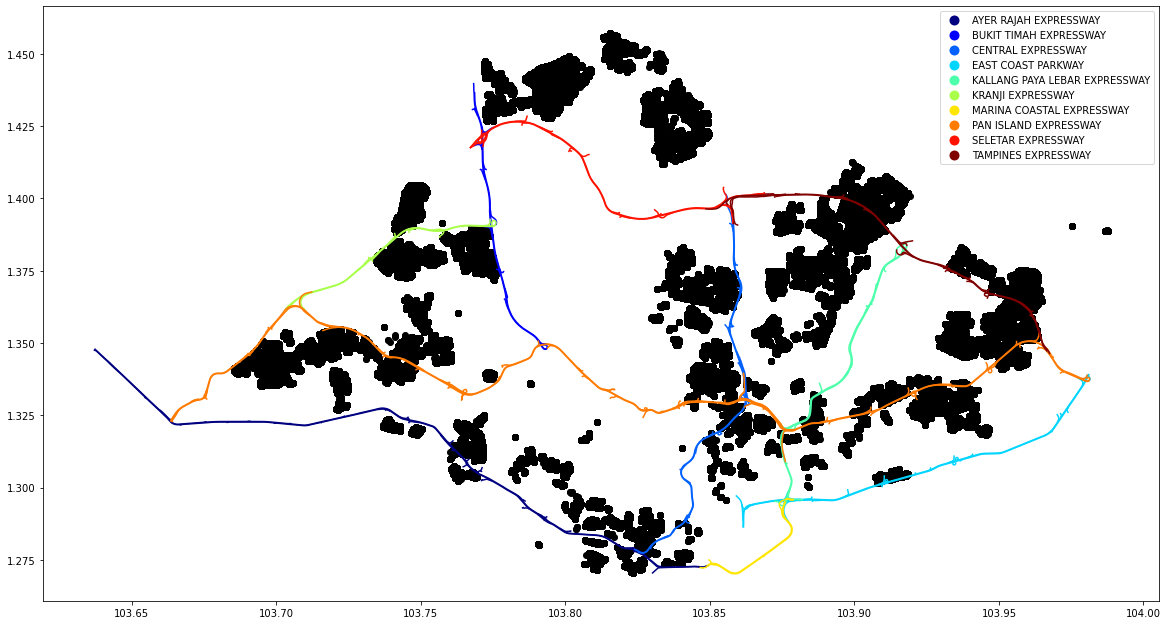

In [17]:
fig, ax = plt.subplots(figsize=(20,14))

expressway_map.plot(ax=ax, cmap="jet", column="road_name", legend=True)
resale_map.plot(ax=ax, color="black");

# Finding HDB Flats near the expressway

To retreive the HDB flats that are near the expressway, we set a buffer of about 150m around the expressways. This buffer is an estimate as literature review has shown that it is best to keep a distance of about 500 feet (equivalent to about 150m) from the highway.
<br>(Ref: https://www.latimes.com/local/california/la-me-freeway-pollution-what-you-can-do-20171230-htmlstory.html)

## Setting a buffer of 150m around the expressway

Note that the current crs of `expressway_map` is EPSG: 4326. The units of this crs is in degrees.

In [18]:
expressway_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

To add a buffer of 150m, we will need to convert `expressway_map` to projected crs (epsg=3414 for Singapore). This is required so that we can apply distance by meters.

In [19]:
# Convert expressway_map to projected crs (epsg=3414 for Singapore)
expressway_map_projected = expressway_map.to_crs(epsg=3414)
expressway_map_projected.crs

<Derived Projected CRS: EPSG:3414>
Name: SVY21 / Singapore TM
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Singapore - onshore and offshore.
- bounds: (103.59, 1.13, 104.07, 1.47)
Coordinate Operation:
- name: Singapore Transverse Mercator
- method: Transverse Mercator
Datum: SVY21
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
# Add buffer of 150m to expressway
buffer_dist = 150
expressway_map_projected_buffer150 = expressway_map_projected["geometry"].buffer(distance=buffer_dist)

# Convert back to epsg=4326 and add back to expressway_map
expressway_map_projected_buffer150 = expressway_map_projected_buffer150.to_crs(epsg=4326)
expressway_map_buffered = gpd.GeoDataFrame(expressway_map["road_name"], geometry=expressway_map_projected_buffer150)
expressway_map_buffered

,road_name,geometry
0,AYER RAJAH EXPRESSWAY,"POLYGON ((103.63591 1.34841, 103.63594 1.34848..."
1,BUKIT TIMAH EXPRESSWAY,"POLYGON ((103.76708 1.43664, 103.76702 1.43705..."
2,CENTRAL EXPRESSWAY,"POLYGON ((103.82388 1.27717, 103.82347 1.27737..."
3,EAST COAST PARKWAY,"POLYGON ((103.86101 1.28493, 103.86093 1.28496..."
4,KALLANG PAYA LEBAR EXPRESSWAY,"POLYGON ((103.87293 1.29379, 103.87209 1.29391..."
5,KRANJI EXPRESSWAY,"POLYGON ((103.70194 1.36065, 103.70193 1.36067..."
6,MARINA COASTAL EXPRESSWAY,"POLYGON ((103.84718 1.27359, 103.84734 1.27357..."
7,PAN ISLAND EXPRESSWAY,"POLYGON ((103.66209 1.32283, 103.66208 1.32285..."
8,SELETAR EXPRESSWAY,"POLYGON ((103.76564 1.41738, 103.76564 1.41739..."
9,TAMPINES EXPRESSWAY,"POLYGON ((103.84974 1.39764, 103.85064 1.39763..."


## Visualisation of Buffered Expressway Map and HDB map

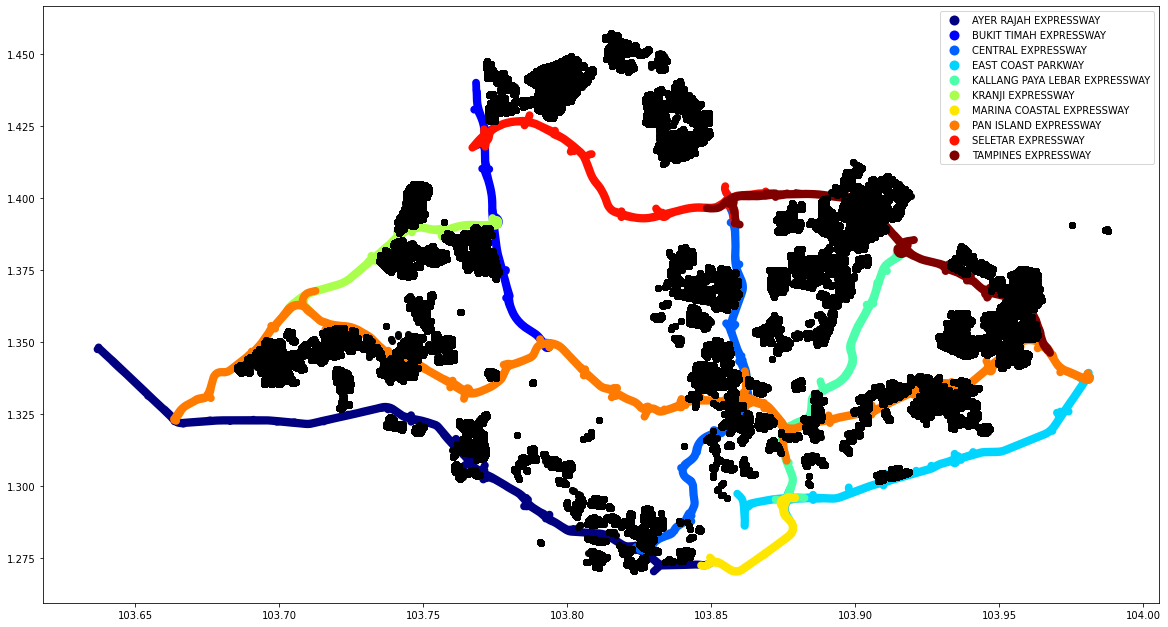

In [21]:
fig, ax = plt.subplots(figsize=(20,14))

expressway_map_buffered.plot(ax=ax, cmap="jet", column="road_name", legend=True)
resale_map.plot(ax=ax, color="black");

## Finding HDB flats within 150m of expressway

In [22]:
# Finding HDB flats within the 150m buffer of the expressway
intersection = gpd.overlay(resale_map, expressway_map_buffered, how="intersection")

The below code chunk shows that there are 12215 HDB flats within 150m of the expressway.

In [23]:
intersection.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12215 entries, 0 to 12214
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   month                12215 non-null  datetime64[ns]
 1   town                 12215 non-null  object        
 2   flat_type            12215 non-null  object        
 3   block                12215 non-null  object        
 4   street_name          12215 non-null  object        
 5   storey_range         12215 non-null  object        
 6   floor_area_sqm       12215 non-null  float64       
 7   flat_model           12215 non-null  object        
 8   lease_commence_date  12215 non-null  int64         
 9   remaining_lease      12215 non-null  object        
 10  resale_price         12215 non-null  float64       
 11  address              12215 non-null  object        
 12  x                    12215 non-null  float64       
 13  y                    12

## Visualisation of the HDB flats within 150m of expressway

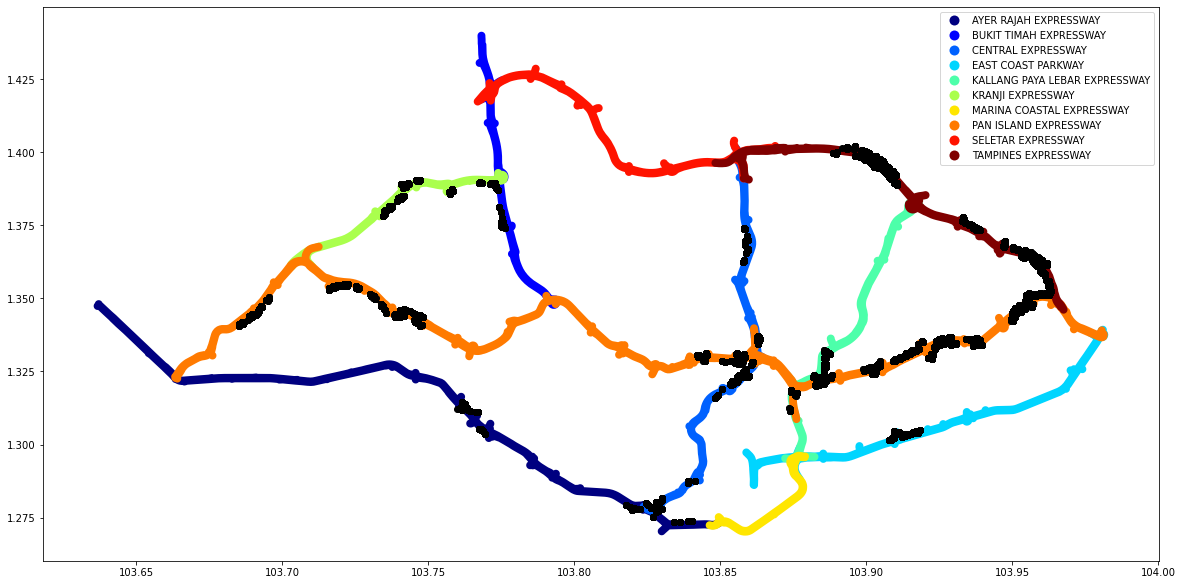

In [24]:
fig, ax = plt.subplots(figsize=(20,14))
expressway_map_buffered.plot(ax=ax, cmap="jet", column="road_name", legend=True)
intersection.plot(ax=ax, color="black");

## Adding column of whether near expressway to resale data

In [25]:
# Obtain a list of addresses that are near expressway
addresses_near_expressway = intersection["address"].unique()

# Add a column near_expressway to resale data
resale["near_expressway"] = resale["address"].apply(lambda x: True if x in addresses_near_expressway else False)
resale["near_expressway"].value_counts()

False    129114
True      11528
Name: near_expressway, dtype: int64

From the above, we note that there is a difference between the number of flats in intersection data (12215) and the number of flats marked True in our final resale dataset. We investigate the difference using the below code chunks and find that the discrepency is because certain HDB flats fall within 150m of more than one expressway. Hence, each of these HDB flats are featured twice in the intersection dataset.

In [26]:
# Create a list of all addresses where there is a difference
addresses_to_check = []
for add in addresses_near_expressway:
    num_in_resale = len(resale[resale["address"] == add])
    num_in_intersection = len(intersection[intersection["address"] == add])
    if num_in_resale != num_in_intersection:
        addresses_to_check.append(add)
        
# Picking one address to check
sample = random.choice(addresses_to_check)

# Check on resale dataset
resale[resale["address"] == sample]

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,address,x,y,latitude,longitude,geometry,near_expressway
37183,2018-10-01,BUKIT PANJANG,2 ROOM,488,SEGAR RD,13 TO 15,47.0,Model A,2014,95 years 02 months,223000.0,488 SEGAR RD,21110.272428,41272.409649,1.389527,103.771409,POINT (103.77141 1.38953),True
39132,2018-11-01,BUKIT PANJANG,2 ROOM,488,SEGAR RD,10 TO 12,47.0,Model A,2014,95 years 01 month,228000.0,488 SEGAR RD,21110.272428,41272.409649,1.389527,103.771409,POINT (103.77141 1.38953),True
40945,2018-12-01,BUKIT PANJANG,2 ROOM,488,SEGAR RD,07 TO 09,47.0,Model A,2014,95 years,213000.0,488 SEGAR RD,21110.272428,41272.409649,1.389527,103.771409,POINT (103.77141 1.38953),True
43905,2019-02-01,BUKIT PANJANG,2 ROOM,488,SEGAR RD,07 TO 09,47.0,Model A,2014,94 years 10 months,220888.0,488 SEGAR RD,21110.272428,41272.409649,1.389527,103.771409,POINT (103.77141 1.38953),True
45285,2019-03-01,BUKIT PANJANG,2 ROOM,488,SEGAR RD,10 TO 12,47.0,Model A,2014,94 years 10 months,242000.0,488 SEGAR RD,21110.272428,41272.409649,1.389527,103.771409,POINT (103.77141 1.38953),True
46980,2019-04-01,BUKIT PANJANG,3 ROOM,488,SEGAR RD,04 TO 06,67.0,Model A,2014,94 years 09 months,295000.0,488 SEGAR RD,21110.272428,41272.409649,1.389527,103.771409,POINT (103.77141 1.38953),True
46982,2019-04-01,BUKIT PANJANG,3 ROOM,488,SEGAR RD,04 TO 06,67.0,Model A,2014,94 years 08 months,300888.0,488 SEGAR RD,21110.272428,41272.409649,1.389527,103.771409,POINT (103.77141 1.38953),True
48881,2019-05-01,BUKIT PANJANG,3 ROOM,488,SEGAR RD,01 TO 03,67.0,Model A,2014,94 years 07 months,294000.0,488 SEGAR RD,21110.272428,41272.409649,1.389527,103.771409,POINT (103.77141 1.38953),True
50928,2019-06-01,BUKIT PANJANG,2 ROOM,488,SEGAR RD,01 TO 03,47.0,Model A,2014,94 years 06 months,215000.0,488 SEGAR RD,21110.272428,41272.409649,1.389527,103.771409,POINT (103.77141 1.38953),True
50929,2019-06-01,BUKIT PANJANG,2 ROOM,488,SEGAR RD,10 TO 12,47.0,Model A,2014,94 years 06 months,238000.0,488 SEGAR RD,21110.272428,41272.409649,1.389527,103.771409,POINT (103.77141 1.38953),True


In [27]:
# Check on intersection dataset
intersection[intersection["address"] == sample]

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,address,x,y,latitude,longitude,road_name,geometry
6786,2018-10-01,BUKIT PANJANG,2 ROOM,488,SEGAR RD,13 TO 15,47.0,Model A,2014,95 years 02 months,223000.0,488 SEGAR RD,21110.272428,41272.409649,1.389527,103.771409,BUKIT TIMAH EXPRESSWAY,POINT (103.77141 1.38953)
6791,2018-11-01,BUKIT PANJANG,2 ROOM,488,SEGAR RD,10 TO 12,47.0,Model A,2014,95 years 01 month,228000.0,488 SEGAR RD,21110.272428,41272.409649,1.389527,103.771409,BUKIT TIMAH EXPRESSWAY,POINT (103.77141 1.38953)
6799,2018-12-01,BUKIT PANJANG,2 ROOM,488,SEGAR RD,07 TO 09,47.0,Model A,2014,95 years,213000.0,488 SEGAR RD,21110.272428,41272.409649,1.389527,103.771409,BUKIT TIMAH EXPRESSWAY,POINT (103.77141 1.38953)
6810,2019-02-01,BUKIT PANJANG,2 ROOM,488,SEGAR RD,07 TO 09,47.0,Model A,2014,94 years 10 months,220888.0,488 SEGAR RD,21110.272428,41272.409649,1.389527,103.771409,BUKIT TIMAH EXPRESSWAY,POINT (103.77141 1.38953)
6817,2019-03-01,BUKIT PANJANG,2 ROOM,488,SEGAR RD,10 TO 12,47.0,Model A,2014,94 years 10 months,242000.0,488 SEGAR RD,21110.272428,41272.409649,1.389527,103.771409,BUKIT TIMAH EXPRESSWAY,POINT (103.77141 1.38953)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8004,2022-06-01,BUKIT PANJANG,2 ROOM,488,SEGAR RD,10 TO 12,47.0,Model A,2014,91 years 06 months,280000.0,488 SEGAR RD,21110.272428,41272.409649,1.389527,103.771409,KRANJI EXPRESSWAY,POINT (103.77141 1.38953)
8029,2022-07-01,BUKIT PANJANG,2 ROOM,488,SEGAR RD,07 TO 09,47.0,2-room,2014,91 years 06 months,280000.0,488 SEGAR RD,21110.272428,41272.409649,1.389527,103.771409,KRANJI EXPRESSWAY,POINT (103.77141 1.38953)
8053,2022-09-01,BUKIT PANJANG,2 ROOM,488,SEGAR RD,13 TO 15,47.0,Model A,2014,91 years 04 months,290000.0,488 SEGAR RD,21110.272428,41272.409649,1.389527,103.771409,KRANJI EXPRESSWAY,POINT (103.77141 1.38953)
8054,2022-09-01,BUKIT PANJANG,2 ROOM,488,SEGAR RD,13 TO 15,47.0,Model A,2014,91 years 04 months,305000.0,488 SEGAR RD,21110.272428,41272.409649,1.389527,103.771409,KRANJI EXPRESSWAY,POINT (103.77141 1.38953)


# Exporting updated dataset to csv

In [28]:
resale.to_csv("data/final_resale_flat_dataset.csv", index=False)

# Analysis of proximity to expressway and resale prices

## Descriptive statistics

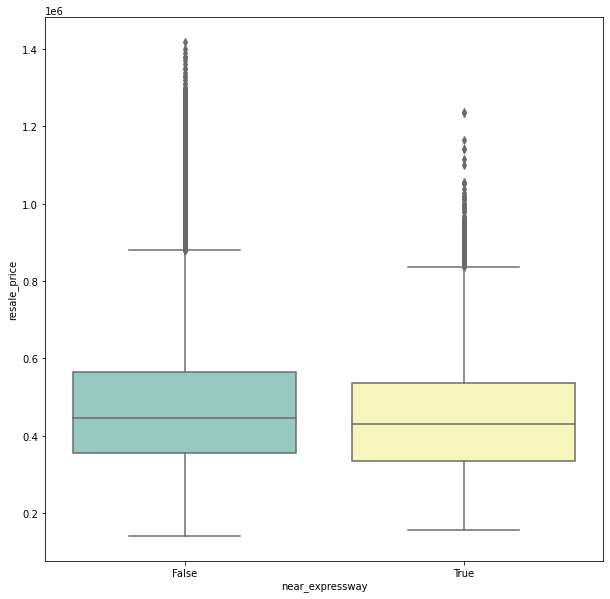

In [29]:
# Plot a boxplot of resale price by whether they are near expressway
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(data=resale, x="near_expressway", y="resale_price", palette="Set3");

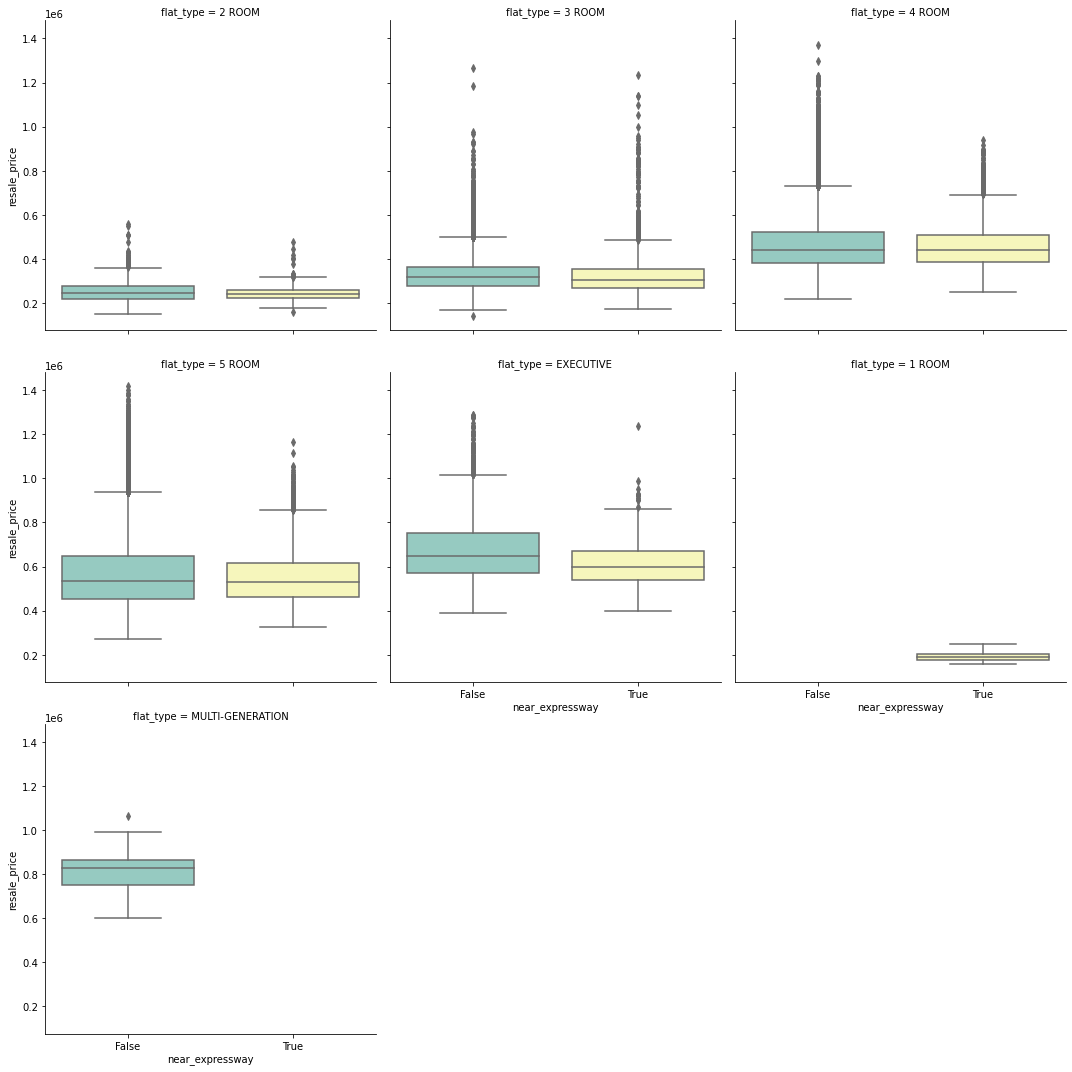

In [31]:
# Plot a boxplot of resale price by whether they are near expressway, differentiated by flat_type
sns.catplot(data=resale, x="near_expressway", y="resale_price", palette="Set3", kind="box", col="flat_type", col_wrap=2);

In [41]:
# Checking the count of HDBs for each category
resale.groupby("flat_type")["near_expressway"].value_counts()

flat_type         near_expressway
1 ROOM            True                  57
2 ROOM            False               1783
                  True                 334
3 ROOM            False              29612
                  True                3287
4 ROOM            False              54551
                  True                4114
5 ROOM            False              32811
                  True                2996
EXECUTIVE         False              10287
                  True                 740
MULTI-GENERATION  False                 70
Name: near_expressway, dtype: int64

As there is insufficient data for flat types 1-room and multi-generation, we will exclude them from our analysis. From the plots, it seems that the mean resale price of HDBs near expressway is lower than that for HDBs not near expressway. We will confirm whether the difference is significant using a statistical test.

## Hypothesis Testing

Defining Hypothesis:
<br>**H₀**: The mean of resale price is equal for HDBs near expressway and not near expressway
<br>**H₁**: The mean of resale price is lower for HDBs near expressway compared to HDBs not near expressway

As sample size is large, we will use the z-test.

In [58]:
flat_types_to_check = ["2 ROOM", "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE"]

for t in flat_types_to_check:
    near_hdb = resale[(resale["near_expressway"] == True) & (resale["flat_type"] == t)]["resale_price"]
    notnear_hdb = resale[(resale["near_expressway"] == False) & (resale["flat_type"] == t)]["resale_price"]
    
    print(f"Hypothesis Testing for {t.lower()} HDBs")
    print(f"Mean of resale price for {t.lower()} HDBs near expressway: {near_hdb.mean():.2f}")
    print(f"Mean of resale price for {t.lower()} HDBs not near expressway: {notnear_hdb.mean():.2f}")
    print(f"Approximate difference: {notnear_hdb.mean() - near_hdb.mean():.0f}")
    
    results = ztest(near_hdb, notnear_hdb, alternative="smaller")
    print(f"Test Statistic: {results[0]:.3f}")
    print(f"P-Value: {results[1]}\n")

Hypothesis Testing for 2 room HDBs
Mean of resale price for 2 room HDBs near expressway: 246284.60
Mean of resale price for 2 room HDBs not near expressway: 252597.56
Approximate difference: 6313
Test Statistic: -2.330
P-Value: 0.009911139297098021

Hypothesis Testing for 3 room HDBs
Mean of resale price for 3 room HDBs near expressway: 323473.42
Mean of resale price for 3 room HDBs not near expressway: 331850.87
Approximate difference: 8377
Test Statistic: -5.383
P-Value: 3.6673150279096e-08

Hypothesis Testing for 4 room HDBs
Mean of resale price for 4 room HDBs near expressway: 459668.32
Mean of resale price for 4 room HDBs not near expressway: 471070.14
Approximate difference: 11402
Test Statistic: -5.389
P-Value: 3.5441927127976104e-08

Hypothesis Testing for 5 room HDBs
Mean of resale price for 5 room HDBs near expressway: 554445.95
Mean of resale price for 5 room HDBs not near expressway: 569696.28
Approximate difference: 15250
Test Statistic: -5.190
P-Value: 1.0498689309696564e

As the p-values for all HDB types are less than 0.05, we have sufficient evidence to reject the null hypothesis for all HDB types. This means that at significance level of 0.05, the mean resale price for 2-room, 3-room, 4-room, 5-room and executive HDBs near expressway is significantly lower than that of HDBs not near expressways.

# Limitations
This project recognises that HDB prices are affected by many different factors and comparing resale prices only by its proximity to expressway could undermine the effects of other factors, e.g., size of HDB and remaining lease period. Future iterations of the project will explore the effect of other factors that could affect HDB resale prices and generate predictions for the prices. 

# References and Acknowledgements
[1] [Geocoding Singapore Coordinates: OneMap API](https://towardsdatascience.com/geocoding-singapore-coordinates-onemap-api-3e1542bf26f7)
<br>[2] [Z Test Statistics Formula & Python Implementation](https://towardsdatascience.com/z-test-statistics-formula-python-implementation-3755d67ba0e7)